In [5]:
import numpy as np
import tomosipo as ts
import matplotlib.pyplot as plt
import nibabel as nib
import math

# Config from the file (mm)
SID_mm = 385.0           # "sid = 385mm"
aperture_deg = 9.0       # "aperture-angle = 9deg"
px_mm = 0.0495           # "pixel-size = 0.0495mm"

# not sure about this, maybe it can be swapped??
COLS = 2304
ROWS = 1300

object_height_mm = 5.0
n_slices = 70            
recon_slices_range = (40, 70)  

# "Stepsize8mm13x13"
Kx = 13
Ky = 13
step_mm = 8.0  

# Optional regularization defaults from your code / config-ish
alpha = 1e-6
sparsity = 5  # not used directly in this script, but noted

# Conversion to m
mm2m = 1e-3
SID = SID_mm * mm2m # source- detector distance
px = px_mm * mm2m # pixel size 
dx = dy = step_mm * mm2m # source grid spacing 

# not sure about this! 
SDD = SID

# detector size 
DET_W = COLS * px
DET_H = ROWS * px



In [6]:
# Detector pixel direction vectors (u,v) and detector origin (center pixel at DP)
det_pos = np.array([[-SDD/2, 0.0, 0.0]])  # detector plane center at z = -SDD/2
det_v   = np.array([[0.0,  px, 0.0]])     
det_u   = np.array([[0.0,  0.0,  px]])    

# 13x13 source grid
x0 = -(Kx - 1) * dx / 2.0
y0 = -(Ky - 1) * dy / 2.0
src_pos = []
for j in range(Ky):
    xs = [x0 + i * dx for i in range(Kx)]
    if j % 2 == 1:
        xs = xs[::-1]
    y = y0 + j * dy
    for xx in xs:
        src_pos.append([+SDD/2, y, xx])  # source plane at z = +SDD/2
src_pos = np.array(src_pos, dtype=np.float64)
V = len(src_pos)

det_pos_all = np.repeat(det_pos, V, axis=0)
det_v_all   = np.repeat(det_v,   V, axis=0)
det_u_all   = np.repeat(det_u,   V, axis=0)

#Volume geoemtry 
# z-size = object height
Sz = object_height_mm * mm2m

# For x,y in world units, a simple consistent choice with your symmetric ±SDD/2 setup is:
# Mid-plane magnification from detector to z=0 is (distance source->plane)/(source->detector) = (SDD/2)/SDD = 0.5.
# So mid-plane FOV roughly ~ 0.5 * detector physical size.
z_det = -SDD/2.0                   # detector plane z
z_src = +SDD/2.0  
z_center = z_det + 0.5 * Sz
M_center = (z_src - z_center) / SDD 

Sx = M_center * DET_W
Sy = M_center * DET_H

vg = ts.volume(
    shape=(n_slices, 64, 64),      
    size=(Sz, Sy, Sx),             
    pos=(0.0, 0.0, 0.0)            
)


x_true = np.ones(vg.shape, dtype=np.float32)
m = 16
x_true[m:-m, m:-m, m:-m] = 100.0  

pg = ts.cone_vec(
    shape=(ROWS, COLS),
    src_pos=src_pos,
    det_pos=det_pos_all,
    det_v=det_v_all,
    det_u=det_u_all,
)

A = ts.operator(vg, pg)
y = A(x_true)  
projs = y

# Put view axis first
axes = np.array(projs.shape)
v_axis = int(np.where(axes == V)[0][0])
projs_v_first = np.moveaxis(projs, v_axis, 0)



In [7]:
# Helper functions (same as the old code)
def volume_bbox_world(vg):
    Sz, Sy, Sx = vg.size
    pos_attr = getattr(vg, "pos", 0.0)
    arr = np.array(pos_attr, dtype=float).ravel()
    if arr.size >= 3: cz, cy, cx = arr[:3]
    else: cz, cy, cx = 0.0, 0.0, 0.0
    return (cz - Sz/2, cz + Sz/2, cy - Sy/2, cy + Sy/2, cx - Sx/2, cx + Sx/2)

def world_to_index_xy_vec(vg, y_w, x_w):
    zmin, zmax, ymin, ymax, xmin, xmax = volume_bbox_world(vg)
    Nz, Ny, Nx = vg.shape
    iy = (y_w - ymin) / (ymax - ymin) * (Ny - 1)
    ix = (x_w - xmin) / (xmax - xmin) * (Nx - 1)
    return iy, ix

def z_of_index_center(vg, k):
    zmin, zmax, _, _, _, _ = volume_bbox_world(vg)
    Nz = vg.shape[0]
    dz = (zmax - zmin) / Nz
    return zmin + (k + 0.5) * dz

rr, cc = np.meshgrid(np.arange(ROWS), np.arange(COLS), indexing='ij')
r0 = (ROWS - 1)/2.0
c0 = (COLS - 1)/2.0
rv = (rr - r0).astype(np.float64)
cu = (cc - c0).astype(np.float64)

def map_view_to_zslice(proj, i, z_world):
    proj = proj.astype(np.float32)

    S  = src_pos[i]
    DP = det_pos_all[i]
    DV = det_v_all[i]
    DU = det_u_all[i]

    P = DP[None,None,:] + rv[...,None]*DV[None,None,:] + cu[...,None]*DU[None,None,:]

    denom = P[..., 0] - S[0]      # z-component difference
    valid = np.abs(denom) > 1e-12
    t = np.empty_like(denom)
    t[valid] = (z_world - S[0]) / denom[valid]
    valid &= (t > 0.0)
    if not np.any(valid):
        Ny, Nx = vg.shape[1], vg.shape[2]
        return np.zeros((Ny, Nx), dtype=np.float32)

    Sbc = S[None,None,:]
    R = Sbc + t[...,None] * (P - Sbc)
    y_w = R[...,1]; x_w = R[...,2]

    Ny, Nx = vg.shape[1], vg.shape[2]
    iy_f, ix_f = world_to_index_xy_vec(vg, y_w, x_w)
    inb = valid & (iy_f >= 0) & (iy_f <= Ny-1) & (ix_f >= 0) & (ix_f <= Nx-1)
    if not np.any(inb):
        return np.zeros((Ny, Nx), dtype=np.float32)

    iyf = iy_f[inb]; ixf = ix_f[inb]
    iy0 = np.floor(iyf).astype(np.int64); iy1 = iy0 + 1
    ix0 = np.floor(ixf).astype(np.int64); ix1 = ix0 + 1
    wy = iyf - iy0; wx = ixf - ix0

    samp = proj[inb]

    out = np.zeros((Ny, Nx), dtype=np.float32)
    wgt = np.zeros((Ny, Nx), dtype=np.float32)

    w00 = (1-wy)*(1-wx); w01 = (1-wy)*wx; w10 = wy*(1-wx); w11 = wy*wx
    m00 = (iy0>=0)&(iy0<Ny)&(ix0>=0)&(ix0<Nx)
    m01 = (iy0>=0)&(iy0<Ny)&(ix1>=0)&(ix1<Nx)
    m10 = (iy1>=0)&(iy1<Ny)&(ix0>=0)&(ix0<Nx)
    m11 = (iy1>=0)&(iy1<Ny)&(ix1>=0)&(ix1<Nx)

    np.add.at(out, (iy0[m00], ix0[m00]), (samp[m00]*w00[m00]).astype(np.float32))
    np.add.at(out, (iy0[m01], ix1[m01]), (samp[m01]*w01[m01]).astype(np.float32))
    np.add.at(out, (iy1[m10], ix0[m10]), (samp[m10]*w10[m10]).astype(np.float32))
    np.add.at(out, (iy1[m11], ix1[m11]), (samp[m11]*w11[m11]).astype(np.float32))

    np.add.at(wgt, (iy0[m00], ix0[m00]), w00[m00].astype(np.float32))
    np.add.at(wgt, (iy0[m01], ix1[m01]), w01[m01].astype(np.float32))
    np.add.at(wgt, (iy1[m10], ix0[m10]), w10[m10].astype(np.float32))
    np.add.at(wgt, (iy1[m11], ix1[m11]), w11[m11].astype(np.float32))

    mapped = np.zeros_like(out)
    nz = wgt > 0
    mapped[nz] = out[nz] / wgt[nz]
    return mapped

def fft_ramp_filter(img, kmax=None, eps_frac=0.02, alpha=0.01):
    img = img.astype(np.float32)
    Ny, Nx = img.shape
    X = np.fft.fft2(img)
    fx = np.fft.fftfreq(Nx, d=1.0)
    fy = np.fft.fftfreq(Ny, d=1.0)
    FX, FY = np.meshgrid(fx, fy)
    K = 2.0 * np.pi * np.sqrt(FX**2 + FY**2)
    k_nyq = np.pi
    if kmax is None:
        kmax = k_nyq
    eps = 5e-3
    cutoff = 1.0 / (1.0 + np.exp((K**2 - kmax**2) / (eps + 1e-12)))
    dkx = 2.0 * np.pi / Nx
    dky = 2.0 * np.pi / Ny
    dk = min(dkx, dky)
    H = 0.5 * (K + alpha * dk) * cutoff
    Y = H * X
    y = np.fft.ifft2(Y).real.astype(np.float32)
    return y

def reconstruct_volume_meshless(projs_v_first,
                                use_ramp=True,
                                kmax=None, eps_frac=0.02, alpha=0.01):
    Nz, Ny, Nx = vg.shape
    V = projs_v_first.shape[0]
    vol = np.zeros((Nz, Ny, Nx), dtype=np.float32)
    ones_proj = np.ones((ROWS, COLS), dtype=np.float32)
    for k in range(Nz):
        z_w = z_of_index_center(vg, k)
        g_avg = np.zeros((Ny, Nx), dtype=np.float32)
        for i in range(V):
            g_avg += map_view_to_zslice(projs_v_first[i], i, z_w)
        g_avg /= float(V)
        sens = np.zeros_like(g_avg)
        for i in range(V):
            sens += map_view_to_zslice(ones_proj, i, z_w)
        sens /= float(V)
        g_norm = g_avg / (sens + 1e-6)
        vol[k] = fft_ramp_filter(g_norm, kmax=kmax, eps_frac=eps_frac, alpha=alpha) if use_ramp else g_norm.astype(np.float32)
    return vol


/tmp/ipykernel_792727/2213953936.py:101: RuntimeWarning: overflow encountered in exp
  cutoff = 1.0 / (1.0 + np.exp((K**2 - kmax**2) / (eps + 1e-12)))


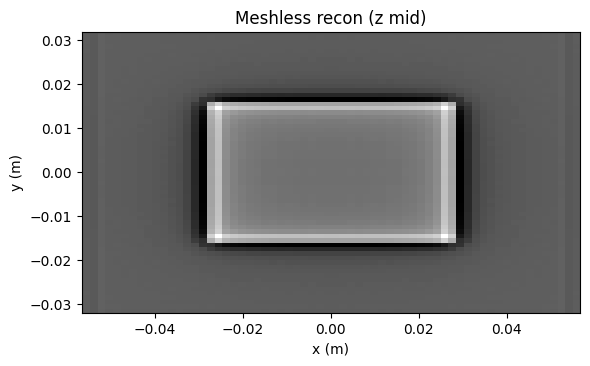

Saved meshless_volume_config.nii


In [8]:
# 3D Reconstruction
x_meshless_3d = reconstruct_volume_meshless(projs_v_first, use_ramp=True, alpha=alpha)

# Visualizing mid-slice
zmin, zmax, ymin, ymax, xmin, xmax = volume_bbox_world(vg)
mid = vg.shape[0] // 2

fig, ax = plt.subplots(figsize=(6, 5))
ax.imshow(
    x_meshless_3d[mid],
    cmap='gray',
    origin='lower',
    extent=[xmin, xmax, ymin, ymax],
)
ax.set_aspect('equal')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('Meshless recon (z mid)')
plt.tight_layout()
plt.show()

# Save for nifty
affine = np.diag([ (xmax - xmin)/vg.shape[2],
                   (ymax - ymin)/vg.shape[1],
                   (zmax - zmin)/vg.shape[0],
                   1.0 ])
nii_img = nib.Nifti1Image(x_meshless_3d.astype(np.float32), affine)
nib.save(nii_img, "meshless_volume_config.nii")
print("Saved meshless_volume_config.nii")